In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from matplotlib import pyplot as plt

from imblearn.combine import SMOTEENN

In [2]:
# read data from csv.
raw_data = pd.read_csv("data/creditcard.csv")

# extract features and labels
features = raw_data.drop(["Time", "Class", "Amount"], axis=1).copy()
labels = raw_data["Class"].copy()

# apply SMOTEENN over-sampling.
# smoteenn = SMOTEENN(sampling_strategy="auto", random_state=42)
# X, y = smoteenn.fit_sample(features, labels)

X = features
y = labels

print("Feature size after SMOTEENN: ", len(X))

Feature size after SMOTEENN:  284807


In [3]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

forest = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
)

In [5]:
%%time

fpr_score = []
tpr_score = []

for (train_idx, test_idx), i in zip(cv.split(X, y), range(5)):
    print("Fold: {}".format(i + 1))

    # train the model
    forest.fit(X.iloc[train_idx], y.iloc[train_idx])

    # predict.
    prediction = forest.predict_proba(X.iloc[test_idx])[:,1]
    # precision, recall, threshold = precision_recall_curve(y[test_idx], prediction)
    fpr, tpr, threshold = roc_curve(y.iloc[test_idx], prediction)
    print("FPR: {}".format(fpr))
    print("TPR: {}".format(tpr))
    # auc_score = auc(fpr, tpr)
    fpr_score.append(fpr)
    tpr_score.append(tpr)


Fold: 1
FPR: [0.         0.         0.         ... 0.99980655 0.99998241 1.        ]
TPR: [0.         0.01010101 0.02020202 ... 1.         1.         1.        ]
Fold: 2
FPR: [0.         0.         0.         ... 0.99984172 0.99998241 1.        ]
TPR: [0.         0.01010101 0.08080808 ... 1.         1.         1.        ]
Fold: 3
FPR: [0.         0.         0.         ... 0.99991207 0.99998241 1.        ]
TPR: [0.         0.01020408 0.26530612 ... 1.         1.         1.        ]
Fold: 4
FPR: [0.         0.         0.         ... 0.99992966 0.99998241 1.        ]
TPR: [0.         0.01020408 0.02040816 ... 1.         1.         1.        ]
Fold: 5
FPR: [0.         0.         0.         ... 0.99977138 0.99978897 1.        ]
TPR: [0.         0.01020408 0.15306122 ... 1.         1.         1.        ]
Wall time: 3min 59s


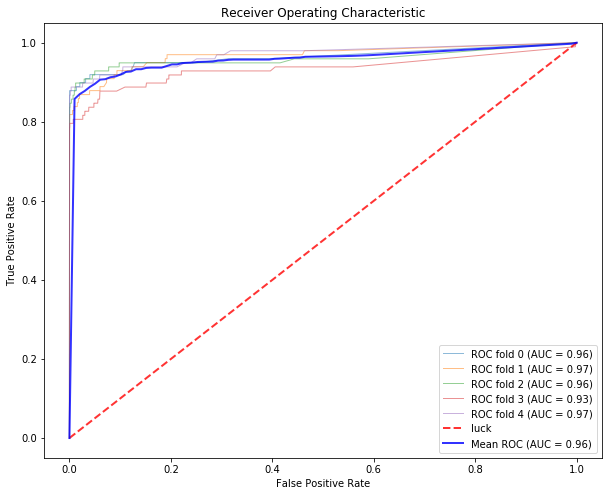

In [8]:
def plot_curve(fpr_score, tpr_score):
    """Plot the ROC curve."""
    
    tpr_score_interpolate = []
    auc_score = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(10, 8))
    
    # plot ROC for each k-fold.
    for i, (fpr, tpr) in enumerate(zip(fpr_score, tpr_score)):
        tpr_score_interpolate.append(np.interp(mean_fpr, fpr, tpr))
        tpr_score_interpolate[-1][0] = 0.
        
        roc_auc = auc(fpr, tpr)
        auc_score.append(roc_auc)
        
        ax.plot(fpr, tpr, lw=1, alpha=.5, label="ROC fold %d (AUC = %.2f)" % (i, roc_auc))
        
    # plot luck line.
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="luck", alpha=.8)
    
    # plot mean ROC.
    mean_tpr = np.mean(tpr_score_interpolate, axis=0)
    mean_tpr[-1] = 1.
    mean_auc = auc(mean_fpr, mean_tpr)
    
    ax.plot(mean_fpr, mean_tpr, lw=2, color="b", alpha=.8, label="Mean ROC (AUC = %.2f)" % (mean_auc))
    
    # show plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    plt.show()
    
plot_curve(fpr_score, tpr_score)